In [1]:
# spacy will be used for lemmatization and stop words removal it's better than nltk
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Downloading the small model 
!python -m spacy download en_core_web_sm

/home/verpen/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2022-09-07 21:47:54.770483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 21:47:54.770501: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-07 21:48:58.189884: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-07 21:48:58.189963: I tensorflow/stream_executor/cuda/cuda_d

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import emoji
import contractions
import string
import nltk 
import emot
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/home/verpen/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2022-09-07 21:49:48.830933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 21:49:48.830950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-07 21:49:49.983927: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-07 21:49:49.983952: I tensorflow/stream_executor/cuda/cuda_d

In [4]:
pd.set_option('max_colwidth', 450)

# Loading data

In [5]:
data = pd.read_csv('/home/verpen/Downloads/Datasets/US_Airline_Tweets.csv')
data.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


# Data analysis


In [6]:
# Remove tweets with sentiment_confidence less than 0.7
modified_data = data[data['airline_sentiment_confidence'] >= 0.7]

# We only interested in the airline_sentiment column and the text column
modified_data = modified_data[['airline_sentiment', 'text', 'airline_sentiment_confidence']]
modified_data.head(5)

,airline_sentiment,text,airline_sentiment_confidence
0,neutral,@VirginAmerica What @dhepburn said.,1.0
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",1.0
4,negative,@VirginAmerica and it's a really big bad thing about it,1.0
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,1.0
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",1.0


In [7]:
# Data is imbalanced, we may need to balance it by taking equal number of samples from every category 
modified_data['airline_sentiment'].value_counts()

negative    7552
neutral     1634
positive    1582
Name: airline_sentiment, dtype: int64

In [8]:
# Display number of positive, negative and neutral tweets
pos = modified_data[modified_data['airline_sentiment'] == 'positive']
neu = modified_data[modified_data['airline_sentiment'] == 'neutral']
neg = modified_data[modified_data['airline_sentiment'] == 'negative'].sample(1600)
modified_data = pd.concat([pos, neu, neg])
modified_data = modified_data.reset_index(drop = True)
modified_data = modified_data.sample(frac = 1)
modified_data = modified_data.reset_index(drop = True)
modified_data.head(5)

,airline_sentiment,text,airline_sentiment_confidence
0,positive,@united Was able to send the DM. All good now.,1.0
1,positive,@SouthwestAir Thank You. We'll be in touch! #MoveAboutTheCountry,1.0
2,positive,"@SouthwestAir Thanks for two smooth, safe and fast flights! #Boston #Houston #LUVSWA http://t.co/elhxUV0Uj1",1.0
3,neutral,@united any plans of restating nonstop service between IAD and South Florida? We miss our flights to FLL.,1.0
4,neutral,@AmericanAir 3127. Just landed in LIT.,1.0


Sentiment Counts:
neutral     1634
negative    1600
positive    1582
Name: airline_sentiment, dtype: int64


([<matplotlib.patches.Wedge at 0x7f2ed260efd0>,
 [Text(0.5320908144466621, 0.9627457427490853, 'neutral'),
  Text(-1.0993672197989155, -0.03730571044227825, 'negative'),
  Text(0.5644355575157282, -0.9441464406605098, 'positive')],
 [Text(0.2902313533345429, 0.525134041499501, '33.93%'),
  Text(-0.5996548471630447, -0.020348569332151772, '33.22%'),
  Text(0.3078739404631244, -0.5149889676330053, '32.85%')])

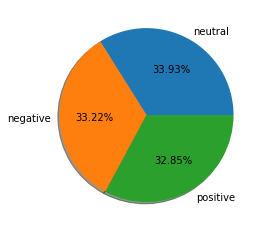

In [9]:
# Graph a pie chart showing with sentiment categories
sent_count = modified_data['airline_sentiment'].value_counts()
print("Sentiment Counts:\n{}".format(sent_count))
plt.pie(sent_count, labels=sent_count.index, shadow=True, autopct="%1.2f%%")

In [10]:
# Label categorical values in the airline_sentiment column with: posisitve = 1, neutral = 0 and negative = -1
modified_data['tweet_sentiment'] = modified_data['airline_sentiment'].apply(lambda x: 1 if x == 'positive' else (0 if x == 'neutral' else -1))
modified_data.head(5)

,airline_sentiment,text,airline_sentiment_confidence,tweet_sentiment
0,positive,@united Was able to send the DM. All good now.,1.0,1
1,positive,@SouthwestAir Thank You. We'll be in touch! #MoveAboutTheCountry,1.0,1
2,positive,"@SouthwestAir Thanks for two smooth, safe and fast flights! #Boston #Houston #LUVSWA http://t.co/elhxUV0Uj1",1.0,1
3,neutral,@united any plans of restating nonstop service between IAD and South Florida? We miss our flights to FLL.,1.0,0
4,neutral,@AmericanAir 3127. Just landed in LIT.,1.0,0


# Data Preprocessing

In [11]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "1st" : "first", 
    "2nd" : "second", 
    "3rd" : "third",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "canx" : "cancel",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "emerg" : "emergency",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "haha" : "laugh",
    "hahaha" 
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrs" : "hour",
    "hrh" : "his royal highness",    
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh_my_god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pls" : "please",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thank" : "thank",
    "thanks" : "thank",
    "thks" : "thank",
    "tho" : "though",
    "thx" : "thank",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "us" : "united states",
    "usa" : "united states",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "ya" : "you",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# This abbreviation list is by @nmaguette from Kaggle

In [12]:
def expand_abbr(abbrev):
    """ This function takes an abbreviated string
        and returns the expanded version with whitespace 
        replaced by underscore """
    
    expanded_abbr = ''
    for k, v in abbreviations.items():        
        if k == abbrev:
            expanded_abbr = v
    return expanded_abbr.replace(' ', '_')

In [13]:
# Load spacy model
# This model will be used for NER and lemmatization
nlp = spacy.load('en_core_web_sm')

In [14]:
def remove_ner(tweet): 
    """ This function removes Named Entity Recognition """
    
    doc = nlp(tweet)
    for word in doc.ents:
        tweet = tweet.replace(word.text, '')    
    return tweet

In [15]:
def emoj_emot_to_text(tweet):
    """ This function converts emojis and emoticons to corresponding text """
    
    # Emoticons 
    emot_obj = emot.core.emot()  
    emoticons_list = emot_obj.emoticons(tweet)['mean']
    for emoticon in emoticons_list: 
        emoticon = emoticon.replace(', ', ' ')
        emoticon = emoticon.replace(' ', '_')
        tweet = tweet + emoticon + " "       
    
    # Emojis 
    tweet = emoji.demojize(tweet) 
    tweet = re.sub(':', '', tweet)
              
    return tweet

In [16]:
stop_words = list(STOP_WORDS)

# Exclude from stop words list the following negative words
stop_words.remove('not')
stop_words.remove('never')
stop_words.remove('none')
stop_words.remove('noone')
stop_words.remove('neither')

In [17]:
def remove_trivial_words(tweet):  
    """ This function Removes stopwords and words with length one or two """
    
    temp = ""
    for word in tweet.split(): 
        if  word not in stop_words:
            if len(word) != 1 and len(word) != 2:
                temp += word + " "
    return temp

In [18]:
negative_words = ['not', 'never', 'none', 'neither', 'no one']

def negation_handling(tweet):
    """ This function uses a static window of size 1 to handle negation.
        If a negative word detected this function will append the word
        (not) with the next word, with underscore connecting the two words.
        For example the sentence: I can't swim ==> I can not_swim """
    
    negated_str = ""
    # Use spacy tokenizer
    doc = nlp(tweet)
    for word in doc:
        word = str(word)
        if word in negative_words:
            negated_str = negated_str + 'not' + "_"         
        else:
            negated_str = negated_str + word + " "
        
    return negated_str

In [19]:
def preprocess_tweets(tweet): 
    #print(f'Original tweet: {tweet}')
    #     Preprocess tweets
    tweet = tweet.lower() # Convert to lower case
    tweet = contractions.fix(tweet) # Remove contractions
    
    #     Remove unecessary characters using regex
    tweet = re.sub('\S+@\S+.\S+', '', tweet) # Remove emails
    tweet = re.sub('@[\S]+', '', tweet) # Remove mentions starting with @       
    tweet = re.sub('(http|https):\/\/[\S]*', '', tweet) # Remove links starting with http or https
    tweet = re.sub('#+\S*|\.+', '', tweet) # Remove Hashtags and dots
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet) # Remove characters repition
    tweet = re.sub(r'&[\S]+;', '', tweet) # Remove html tags, such as &amp;
    tweet = re.sub('\d', '', tweet)  # Remove Numbers    
   
    # Expand abbreviations
    doc = nlp(tweet)
    for word in doc:   
        word = str(word)
        expanded_word = expand_abbr(word)
        if expanded_word != '':
            tweet = tweet.replace(word, expanded_word)
    
    # Remove Named Entity recognition
    tweet = remove_ner(tweet)
    
    # Lemmatization using spacy lemmatizer
    concat_str = ""
    doc = nlp(tweet)
    for word in doc:
        concat_str += word.lemma_ + " "
    tweet = concat_str
    
    # Emojis and Emoticons
    tweet = emoj_emot_to_text(tweet)
    
    # Remove trivial words
    tweet = remove_trivial_words(tweet)
    
    # Handle negations
    tweet = negation_handling(tweet)     
    
    # Remove remaining punctuations
    tweet = re.sub('\W', ' ', tweet)
    
    # Tokenization
    tweet = word_tokenize(tweet)

    return tweet #Return processed tweet as a list

In [20]:
# Preprocess each tweet (text column)
modified_data['Tokens'] = modified_data['text'].apply(preprocess_tweets)

In [21]:
modified_data.sample(5) 

,airline_sentiment,text,airline_sentiment_confidence,tweet_sentiment,Tokens
375,negative,"@united Flight is awful only one lavatory functioning, and people lining up, bumping, etc. because can't use 1st class bathroom. Ridiculous",1.0,-1,"[flight, awful, lavatory, functioning, people, line, bumping, and_so_on, not_use, class, bathroom, ridiculous]"
3827,negative,@AmericanAir @tcunningham10 please call us back to rebook. 7403607771 we can't through!!!!! We need to get to columbus!!!!,1.0,-1,"[united_state, rebook, not_need, columbunited_state]"
2550,negative,@USAirways I've never been treated this badly,1.0,-1,"[not_treat, badly]"
3572,negative,@united agent helps the person in front of me. Finishes up with them and then walks away. The guy behind me is as shocked as I am.,1.0,-1,"[agent, help, person, finish, walk, away, guy, shock]"
4718,positive,@united Joni did a great job on flight 5653 to LAX. Thanks for a great flight.,1.0,1,"[great, job, flight, lax, thank, great, flight]"


In [22]:
# Convert token lists to string 
def convert_list_str(tokens):
    return ' '.join(tokens)
modified_data['String_tokens'] = modified_data['Tokens'].apply(convert_list_str)

# Analyze data after processing

In [23]:
# Count the number of tokens in the dataset after processing
unique_tokens = set()
num_of_tokens = 0
rows = modified_data.shape[0]
for i in range(rows):
    num_of_tokens += len(modified_data['Tokens'][i])        
    for token in modified_data['Tokens'][i]:
        unique_tokens.add(token)
    
print(f'Number of tokens: {num_of_tokens}\nNumber of unique tokens: {len(unique_tokens)}')

Number of tokens: 29520
Number of unique tokens: 4739


In [24]:
# Calculate words occurances 
def occurances_of_words(dataframe, reverse=True):
    freq_words_dic = {}
    rows = dataframe.shape[0]
    
    for i in range(rows):
        for word in dataframe['Tokens'][i]:
            if word in freq_words_dic:
                freq = freq_words_dic[word]
                freq_words_dic[word] = freq + 1
            else:
                freq_words_dic[word] = 1
    return sorted(freq_words_dic.items(), key=lambda x: x[1], reverse=reverse)

In [25]:
# Calculate words occurances in negative tweets
neg_modified_data = modified_data[modified_data['tweet_sentiment'] == -1]
neg_modified_data = neg_modified_data.reset_index(drop=True)
neg_modified_data.head(2)

,airline_sentiment,text,airline_sentiment_confidence,tweet_sentiment,Tokens,String_tokens
0,negative,"@united as for volunteers to give up seats, people did! Now we sit for 25 minutes on plane waiting 4 them to add more people! #letsgo",0.7112,-1,"[volunteer, seat, people, sit, plane, wait, add, people]",volunteer seat people sit plane wait add people
1,negative,@VirginAmerica I was so looking forward to my first flight with you today but it was Cancelled Flightled along with the subsequent one ...,1.0000,-1,"[look, forward, flight, today, cancel, flightle, subsequent]",look forward flight today cancel flightle subsequent


In [26]:
neg_freq_words = occurances_of_words(neg_modified_data)
neg_freq_words

[('flight', 627),
 ('cancel', 179),
 ('delay', 158),
 ('service', 143),
 ('customer', 135),
 ('hold', 130),
 ('wait', 129),
 ('time', 127),
 ('plane', 120),
 ('bag', 109),
 ('hour', 105),
 ('united_state', 99),
 ('try', 98),
 ('help', 95),
 ('bad', 90),
 ('airline', 82),
 ('flightle', 79),
 ('need', 78),
 ('min', 76),
 ('thank', 74),
 ('phone', 73),
 ('late', 71),
 ('miss', 70),
 ('fly', 70),
 ('agent', 68),
 ('gate', 67),
 ('seat', 64),
 ('dollar', 58),
 ('people', 57),
 ('tell', 56),
 ('problem', 52),
 ('ticket', 52),
 ('luggage', 51),
 ('lose', 50),
 ('check', 48),
 ('weather', 48),
 ('sit', 46),
 ('leave', 46),
 ('guy', 45),
 ('pay', 45),
 ('change', 42),
 ('airport', 42),
 ('book', 42),
 ('issue', 41),
 ('like', 41),
 ('day', 37),
 ('line', 36),
 ('home', 35),
 ('experience', 34),
 ('know', 34),
 ('refund', 34),
 ('answer', 33),
 ('work', 32),
 ('email', 32),
 ('flightr', 32),
 ('reservation', 32),
 ('crew', 31),
 ('new', 31),
 ('website', 30),
 ('way', 30),
 ('staff', 30),
 ('han

In [27]:
# Calculate words occurances in positive tweets
pos_modified_data = modified_data[modified_data['tweet_sentiment'] == 1]
pos_modified_data = pos_modified_data.reset_index(drop=True)
pos_modified_data.head(2)

,airline_sentiment,text,airline_sentiment_confidence,tweet_sentiment,Tokens,String_tokens
0,positive,@united Was able to send the DM. All good now.,1.0,1,"[able, send, direct_message, good]",able send direct_message good
1,positive,@SouthwestAir Thank You. We'll be in touch! #MoveAboutTheCountry,1.0,1,"[thank, touch]",thank touch


In [28]:
pos_freq_words = occurances_of_words(pos_modified_data)
pos_freq_words

[('thank', 800),
 ('flight', 307),
 ('great', 196),
 ('good', 173),
 ('service', 139),
 ('love', 120),
 ('fly', 109),
 ('customer', 99),
 ('guy', 98),
 ('awesome', 82),
 ('help', 81),
 ('time', 73),
 ('airline', 72),
 ('Happy_face_or_smiley', 70),
 ('amazing', 68),
 ('appreciate', 67),
 ('work', 66),
 ('crew', 64),
 ('united_state', 64),
 ('response', 47),
 ('gate', 44),
 ('follow', 42),
 ('home', 41),
 ('plane', 40),
 ('new', 38),
 ('know', 38),
 ('nice', 36),
 ('like', 36),
 ('agent', 36),
 ('look', 35),
 ('airplane', 34),
 ('helpful', 33),
 ('staff', 33),
 ('send', 32),
 ('job', 32),
 ('early', 32),
 ('attendant', 32),
 ('bag', 31),
 ('way', 30),
 ('rock', 30),
 ('yes', 30),
 ('day', 29),
 ('team', 28),
 ('experience', 28),
 ('seat', 27),
 ('thumbs_up', 27),
 ('southwest', 26),
 ('trip', 26),
 ('want', 25),
 ('delay', 24),
 ('quick', 24),
 ('happy', 24),
 ('hope', 23),
 ('class', 23),
 ('jetblue', 23),
 ('travel', 22),
 ('check', 22),
 ('ticket', 22),
 ('finally', 22),
 ('people', 2

In [29]:
# Calculate words occurances in neutral tweets
neu_modified_data = modified_data[modified_data['tweet_sentiment'] == 0]
neu_modified_data = neu_modified_data.reset_index(drop=True)
neu_modified_data.head(2)

,airline_sentiment,text,airline_sentiment_confidence,tweet_sentiment,Tokens,String_tokens
0,neutral,@united any plans of restating nonstop service between IAD and South Florida? We miss our flights to FLL.,1.0,0,"[plan, restate, nonstop, service, iad, south, miss, flight, fll]",plan restate nonstop service iad south miss flight fll
1,neutral,@AmericanAir 3127. Just landed in LIT.,1.0,0,"[land, lit]",land lit


In [30]:
neu_freq_words = occurances_of_words(neu_modified_data)
neu_freq_words

[('flight', 429),
 ('fly', 106),
 ('need', 98),
 ('help', 92),
 ('thank', 91),
 ('united_state', 76),
 ('ticket', 64),
 ('change', 60),
 ('know', 58),
 ('direct_message', 56),
 ('way', 56),
 ('fleek', 56),
 ('fleet', 53),
 ('use', 51),
 ('check', 48),
 ('travel', 48),
 ('cancel', 47),
 ('time', 46),
 ('book', 46),
 ('seat', 46),
 ('leave', 45),
 ('follow', 45),
 ('send', 44),
 ('number', 41),
 ('like', 39),
 ('new', 33),
 ('reservation', 33),
 ('add', 32),
 ('chance', 32),
 ('look', 32),
 ('email', 31),
 ('start', 31),
 ('bag', 31),
 ('try', 30),
 ('good', 30),
 ('airport', 30),
 ('think', 29),
 ('tell', 29),
 ('service', 28),
 ('lax', 28),
 ('guy', 28),
 ('question', 28),
 ('trip', 28),
 ('want', 28),
 ('plane', 27),
 ('weather', 26),
 ('dfw', 25),
 ('problem', 25),
 ('pass', 25),
 ('gate', 24),
 ('retweet', 24),
 ('delay', 24),
 ('possible', 23),
 ('snow', 22),
 ('ceo', 22),
 ('ord', 22),
 ('open', 21),
 ('bring', 21),
 ('offer', 21),
 ('pay', 21),
 ('mile', 20),
 ('booking', 20),
 (

In [31]:
def plot_ten_freq_words(freq_words_list, label, color):
    """ Plot a bar chart with the ten most frequent words """
    
    ten_freq_words = [f_item[0] for f_item in freq_words_list]
    occurances = [s_item[1] for s_item in freq_words_list]    
    
    # X ticks position
    x_pos = [x*2 for x in range(10)]

    plt.bar(x_pos, occurances, align='center', width=1.5, alpha=0.8, color=color, label=label)
    plt.xlabel('Most Frequent Words')
    plt.ylabel('Number of occurances')
    plt.legend()
    plt.xticks(x_pos, ten_freq_words, rotation='vertical')
    plt.show()

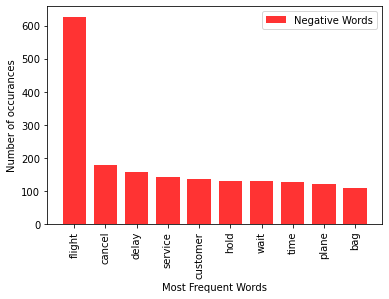

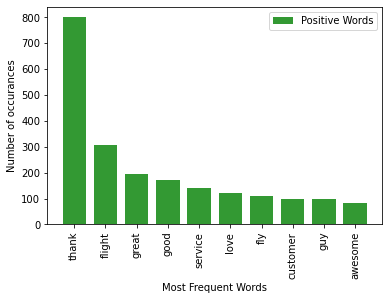

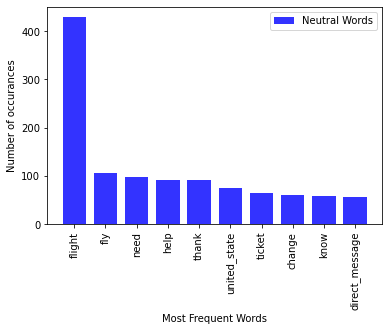

In [32]:
ten_neg_freq_words = neg_freq_words[:10]
ten_neg_freq_words
plot_ten_freq_words(ten_neg_freq_words, 'Negative Words', 'red')
ten_pos_freq_words = pos_freq_words[:10]
ten_pos_freq_words
plot_ten_freq_words(ten_pos_freq_words, 'Positive Words', 'green')
ten_neu_freq_words = neu_freq_words[:10]
ten_neu_freq_words
plot_ten_freq_words(ten_neu_freq_words, 'Neutral Words', 'blue')

# Feature Extraction and training

In [33]:
rem_modified_data = modified_data
indexes = set()
rows = rem_modified_data.shape[0]
for i in range(rows): 
    if rem_modified_data['tweet_sentiment'][i] == -1 or rem_modified_data['tweet_sentiment'][i] == 0:
        for token in rem_modified_data['Tokens'][i]:
            if token == 'thank':
                indexes.add(i)

In [34]:
for i in indexes:
    rem_modified_data = rem_modified_data.drop(index=i)

In [35]:
rem_modified_data = rem_modified_data.reset_index(drop=True)

In [36]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=2500)
tfidf_data = tfidf.fit_transform(rem_modified_data['String_tokens'])
clf_log = cross_val_score(LogisticRegression(), tfidf_data, rem_modified_data['tweet_sentiment'], cv=10, scoring='accuracy')
clf_svm = cross_val_score(SVC(kernel='linear'), tfidf_data, rem_modified_data['tweet_sentiment'], cv=10, scoring='accuracy')

In [37]:
print(clf_log.mean())
print(clf_svm.mean())

0.797963911578753
0.7981831187410587
